In [1]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import numpy as np
from itertools import product
from sklearn.metrics import mean_squared_error

%pylab inline
%matplotlib inline

plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = (14, 7)

/home/yas/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


/home/yas/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Female unemployment in USA from 1948 to 1981 in thousands.

Будем прогнозировать количество нетрудоустроенных женщин в США. Есть данные с 1948 по 1981 год.

In [3]:
df = pd.read_csv('monthly-us-female-20-years-and-o.csv')[:-1]

In [4]:
df.columns = ['month', 'value']
df.month = pd.to_datetime(df['month'], format="%Y-%m")
df.set_index('month', inplace=True)
df.head()

,value
month,
1948-01-01,446.0
1948-02-01,650.0
1948-03-01,592.0
1948-04-01,561.0
1948-05-01,491.0


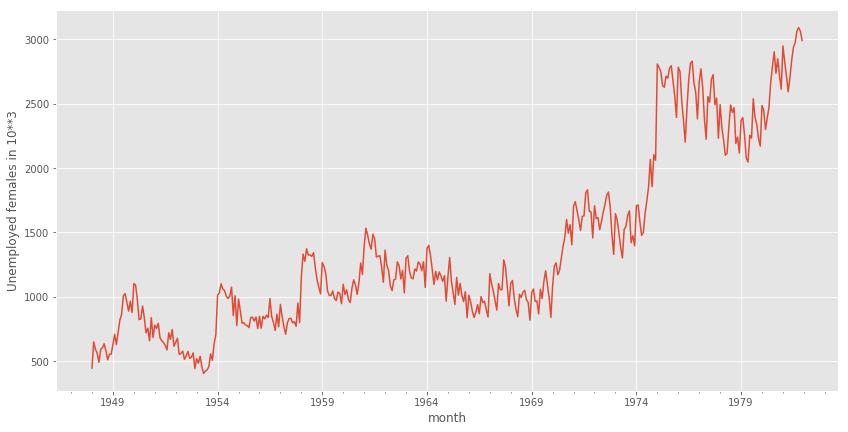

In [6]:
df.value.plot()
plt.ylabel('Unemployed females in 10**3');

Очевидно, что ряд не стационарен. Убедимся в этом:

In [7]:
print ("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.value)[1])

Критерий Дики-Фуллера: p=0.982173


На графике видно, что дисперсия сильно различается, надо ее стабилизировать. Используем преобразование бокса-кокса.

Оптимальный параметр преобразования Бокса-Кокса: -0.148504
Критерий Дики-Фуллера: p=0.888732


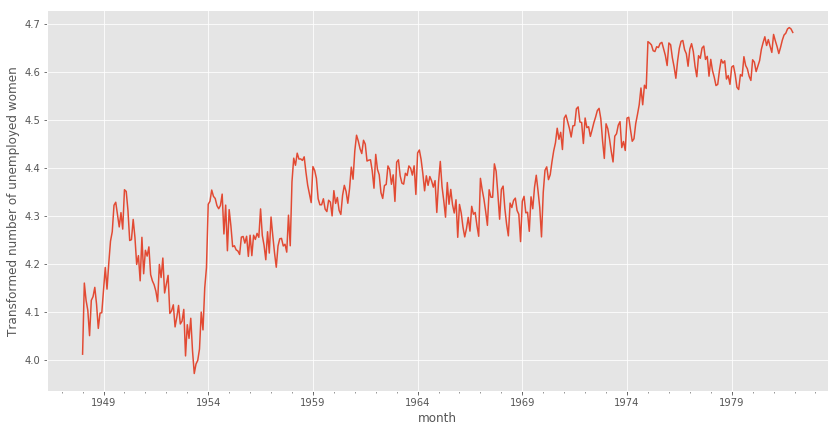

In [8]:
df['value_box'], lmbda = stats.boxcox(df.value)
df.value_box.plot()
plt.ylabel('Transformed number of unemployed women')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.value_box)[1])

С дисперсией получше, но ряд все еще _очень_ нестационарен. Сделаем STL декомпозицию ряда.

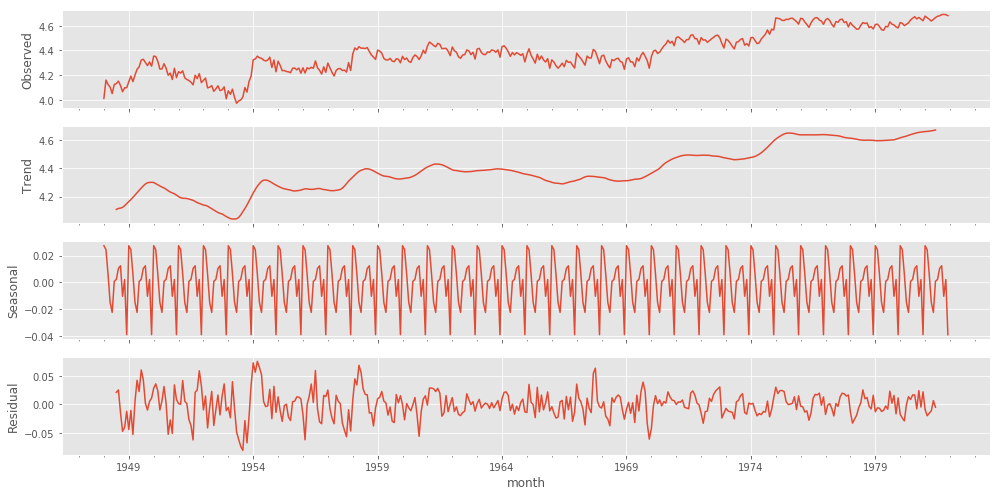

In [10]:
fig = sm.tsa.seasonal_decompose(df.value_box).plot()

При разложении виден очень явный тренд, надо от него избавиться.

Сделаем сезонное дифференцирование.

Критерий Дики-Фуллера: p=0.000031


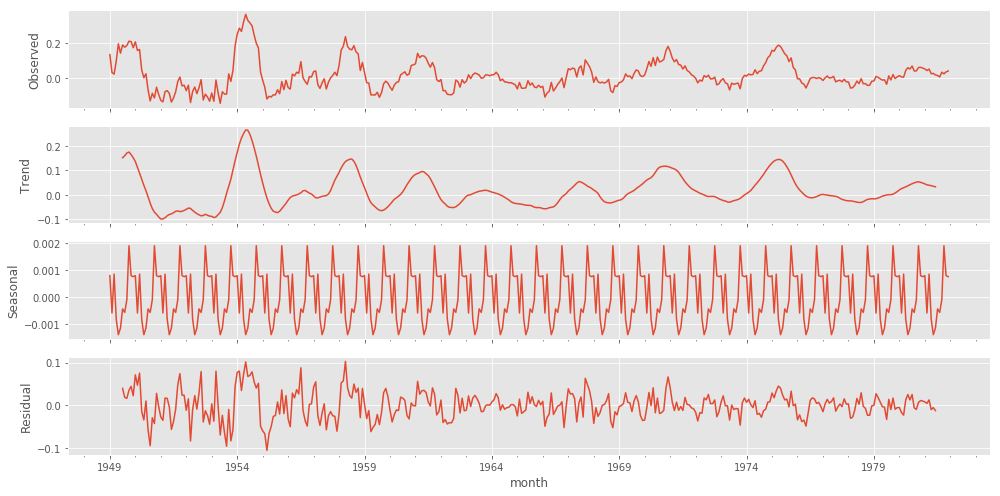

In [11]:
df['value_box_diff'] = df.value_box - df.value_box.shift(12)
fig = sm.tsa.seasonal_decompose(df.value_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.value_box_diff[12:])[1])

В данном случае критерий Дики-Фуллера отвергает гипотезу о нестационарности, причем очень уверенно.
Но видно, что данные - тренд с каким-то шумом. Пока все еще сильно стоит проблема значительного тренда.

Добавим обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


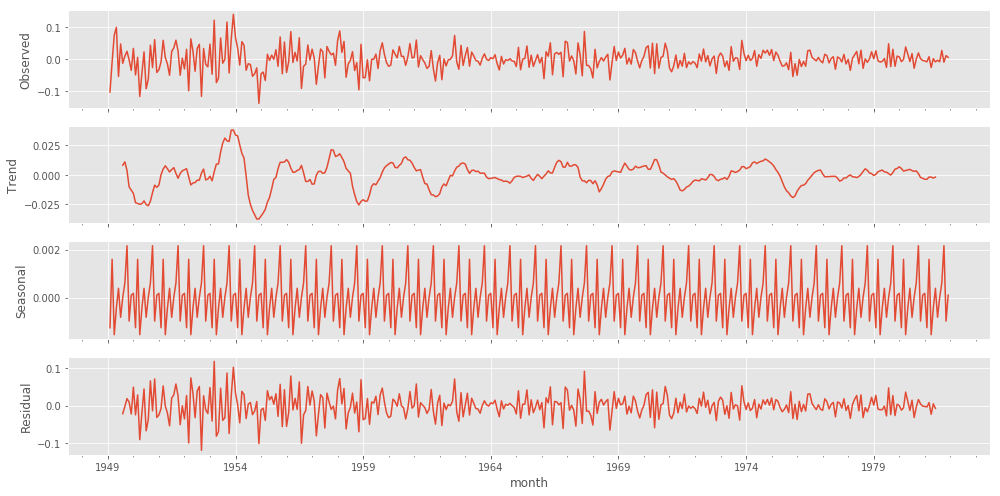

In [12]:
df['value_box_diff2'] = df.value_box_diff - df.value_box_diff.shift(1)
fig = sm.tsa.seasonal_decompose(df.value_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.value_box_diff2[13:])[1])

Теперь немного получше: сезонности нет, тренд стал менее явным, но все еще его масштаб весьма значимый (порядка четверти от всех данных).
Критерий Дики-Фуллера абсолютно отвергает гипотезу о нестационарности.

Давайте продифференцируем еще один раз.

Критерий Дики-Фуллера: p=0.000000


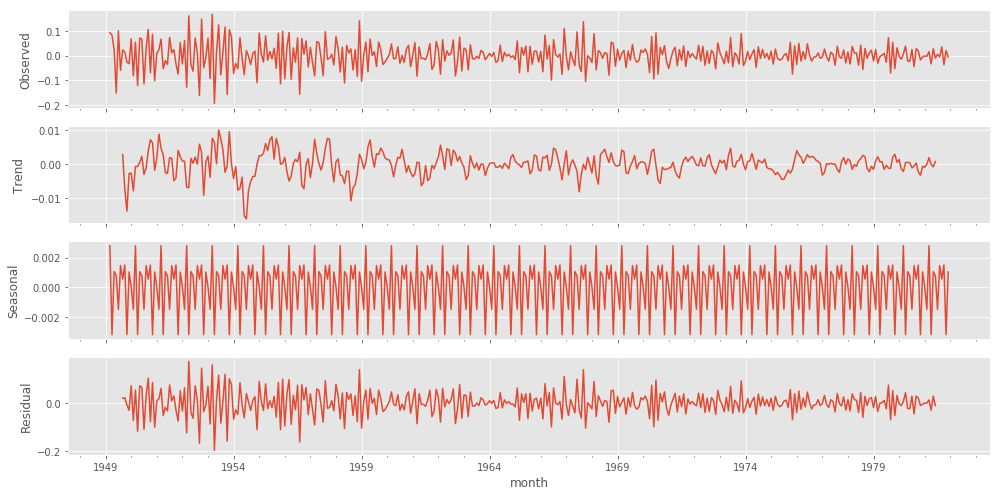

In [13]:
df['value_box_diff3'] = df.value_box_diff2 - df.value_box_diff2.shift(1)
fig = sm.tsa.seasonal_decompose(df.value_box_diff3[14:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.value_box_diff3[14:])[1])

Теперь уже гораздо лучше. Тренд похож на шум, и его порядок не очень большой.
Мы могли бы дифференцировать и дальше, но тогда будет расти и дисперсия ошибки.
Остановимся на этом этапе.

Взглянем на автокорреляцию.

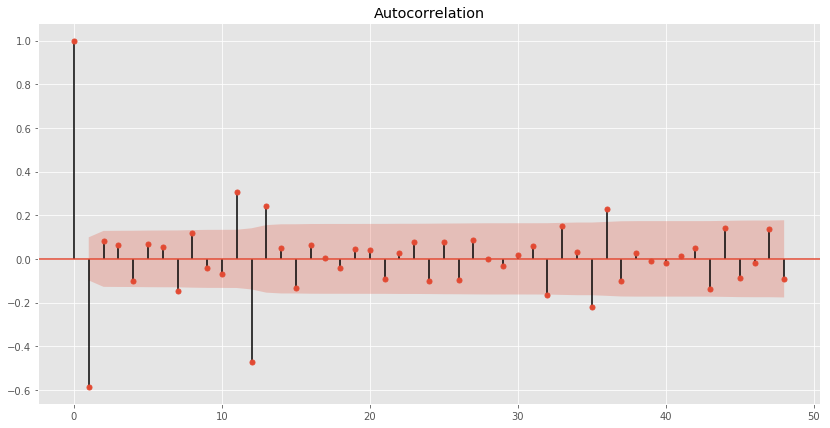

In [14]:
fig = sm.graphics.tsa.plot_acf(df.value_box_diff3[14:].values.squeeze(), lags=48)

Есть значимое значение на лаге 36 - это сезонность. => Q = 3

Видим, что значимые значения на лагах 1 и 11 => q = 11.

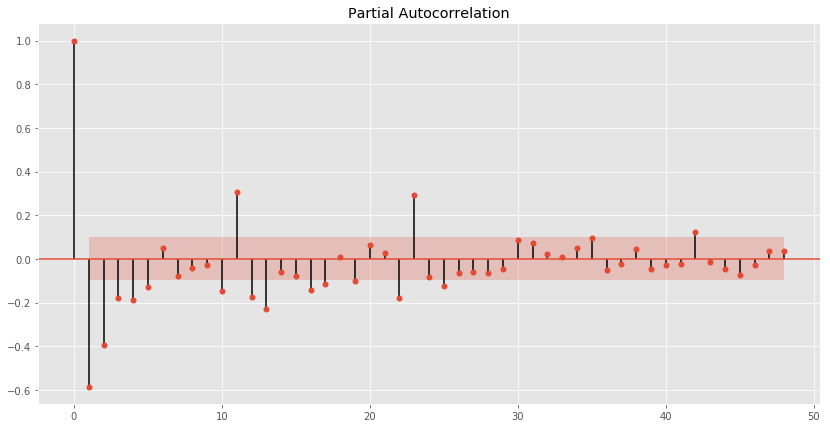

In [15]:
fig = sm.graphics.tsa.plot_pacf(df.value_box_diff3[14:].values.squeeze(), lags=48)

Есть значимое значение на лаге 12 - это сезонность. => P = 1

Видим, что значимые значения на лагах 1, 2 и 11 => p = 11.

Итак, начальные параметры:
    - q = 11
    - Q = 3
    - p = 11
    - P = 1

In [17]:
d = 2
D = 1

ps = [1, 2, 7, 11]
qs = [1, 2, 7, 11]
Ps = range(0, 2)
Qs = range(2, 4)

In [18]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [19]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.value_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (11, 7, 0, 2)
wrong parameters: (11, 7, 0, 3)
wrong parameters: (11, 7, 1, 2)
wrong parameters: (11, 7, 1, 3)
wrong parameters: (11, 11, 0, 2)
wrong parameters: (11, 11, 0, 3)
wrong parameters: (11, 11, 1, 2)
wrong parameters: (11, 11, 1, 3)
CPU times: user 1h 32min 39s, sys: 3min 40s, total: 1h 36min 20s
Wall time: 48min 43s


In [20]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
8   (1, 7, 0, 2) -1680.919716
36  (7, 2, 0, 2) -1680.593131
11  (1, 7, 1, 3) -1680.271396
39  (7, 2, 1, 3) -1679.715033
10  (1, 7, 1, 2) -1679.564527


Путем перебора параметров, найдены оптимальные:
- q = 7
- Q = 2
- p = 1
- P = 0

Одно сезонное и два обычных дифференцирования => D = 1, d = 2

In [21]:
d = 2
D = 1

q = 7
Q = 2
p = 1
P = 0
param = (p, q, P, Q)

In [22]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

model=sm.tsa.statespace.SARIMAX(df.value_box, order=(param[0], d, param[1]), 
                                    seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
aic = model.aic

if aic < best_aic:
    best_model = model
    best_aic = aic
    best_param = param
results.append([param, model.aic])

warnings.filterwarnings('default')

CPU times: user 1min 14s, sys: 3.28 s, total: 1min 17s
Wall time: 37.3 s


In [23]:
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          value_box   No. Observations:                  408
Model:             SARIMAX(1, 2, 7)x(0, 1, 2, 12)   Log Likelihood                 851.460
Date:                            Fri, 15 Dec 2017   AIC                          -1680.920
Time:                                    23:49:24   BIC                          -1636.796
Sample:                                01-01-1948   HQIC                         -1663.460
                                     - 12-01-1981                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6277      0.266     -2.359      0.018      -1.149      -0.106
ma.L1         -0.4944      0.507   

Гипотеза о неавтокореллированности остатков подтверждается.

Критерий Стьюдента: p=0.079045
Критерий Дики-Фуллера: p=0.000000


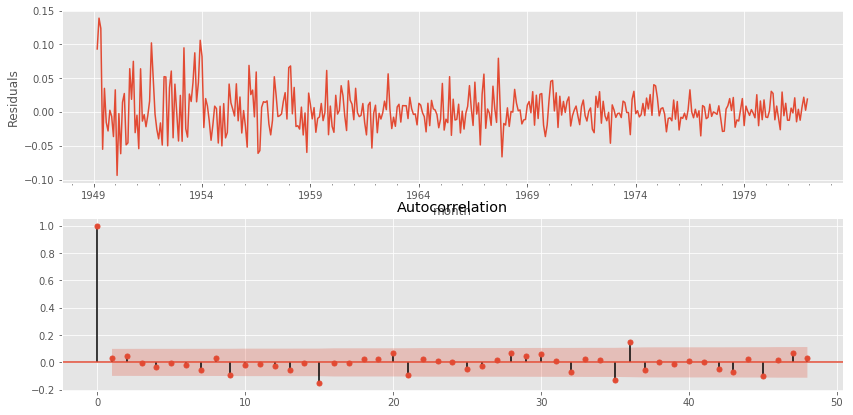

In [24]:
# plt.figure(figsize(15,8))
plt.subplot(2, 1, 1)
best_model.resid[14:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_acf(best_model.resid[14:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[14:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[14:])[1])

Критерий Стьюдента о несмещенности остатков очень неуверенно отвергается.

Остатки действительно похожи на шум, неавтокоррелированы и стационарны. 
Это значит, что мы, скорее всего, не упустили никаких явных закономерностей в данных.

Возможную смещенность остатков можно исправить, простым сдвигом ответов на константу.

In [25]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

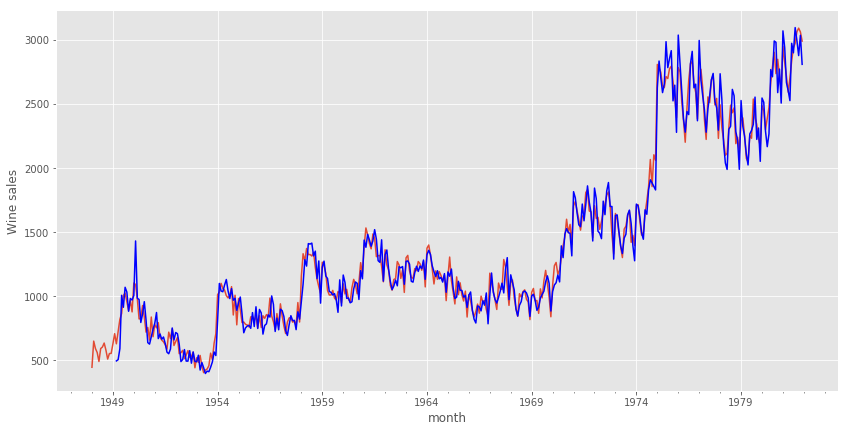

In [26]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
df.value.plot()
df.model[14:].plot(color='b')
plt.ylabel('Wine sales')
pylab.show()

## Прогноз

In [27]:
from pandas.tseries.offsets import MonthBegin

In [28]:
df_len = df.shape[0] - 1

In [29]:
pred = invboxcox(best_model.predict(start=df_len, end=df_len+36), lmbda)

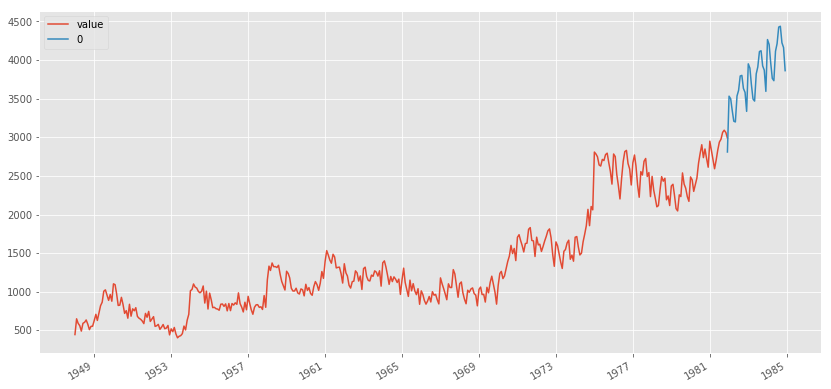

In [31]:
pd.concat([df[['value']], pred]).plot();